In [ ]:
!git clone https://github.com/gbolmier/funk-svd

Cloning into 'funk-svd'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 201 (delta 39), reused 33 (delta 33), pack-reused 135
Receiving objects: 100% (201/201), 55.79 KiB | 13.95 MiB/s, done.
Resolving deltas: 100% (121/121), done.


In [ ]:
%cd /content/funk-svd/


/content/funk-svd


In [ ]:
import multiprocessing as mp
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from funk_svd.dataset import fetch_ml_ratings
from funk_svd.utils import _timer
from funk_svd import SVD

In [ ]:
import pandas as pd
df_train=pd.read_csv('/content/drive/MyDrive/IEEE_Dataset/tr.csv')
df_test=pd.read_csv('/content/drive/MyDrive/IEEE_Dataset/te.csv')

In [ ]:
df_train.head()

,Unnamed: 0,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary
0,2207800,5.0,1,2014-02-08,A0009988MRFQ3TROTQPI,B0096W47NO,9,Bob Macky,Let's not just create something to sell toys a...,Lauren Faust took a chance
1,2356625,5.0,1,2014-02-08,A0009988MRFQ3TROTQPI,B00C0YUY4Q,9,Bob Macky,"In this case I agree, the first season of my l...",Who says the first is the best
2,1042138,5.0,0,2014-10-03,A0009988MRFQ3TROTQPI,B000BMSUBI,3,Bob Macky,Didnt think it could get better..but it did,Probably fav of the series
3,1905647,5.0,0,2014-10-20,A0009988MRFQ3TROTQPI,B004XC5LHS,3,Bob Macky,This is My First Anime ive Ever Watched in Jap...,This Will Set The Bar For Me
4,3344484,5.0,1,2015-04-18,A0009988MRFQ3TROTQPI,B009INAMA8,9,Bob Macky,Its Really Great i Just Wish That They Had All...,Never Judge A Show Before Hand


In [ ]:
df_train.shape

(125194, 10)

In [ ]:
data=df_train.drop(['Unnamed: 0','verified','style','reviewerName','reviewText','summary'],axis=1)
data.head()

,overall,reviewTime,reviewerID,asin
0,5.0,2014-02-08,A0009988MRFQ3TROTQPI,B0096W47NO
1,5.0,2014-02-08,A0009988MRFQ3TROTQPI,B00C0YUY4Q
2,5.0,2014-10-03,A0009988MRFQ3TROTQPI,B000BMSUBI
3,5.0,2014-10-20,A0009988MRFQ3TROTQPI,B004XC5LHS
4,5.0,2015-04-18,A0009988MRFQ3TROTQPI,B009INAMA8


In [ ]:
data1=df_test.drop(['Unnamed: 0','verified','style','reviewerName','reviewText','summary'],axis=1)
data1.head()

,overall,reviewTime,reviewerID,asin
0,5.0,2016-01-06,A0009988MRFQ3TROTQPI,B00V7ORWZE
1,5.0,2014-12-19,A00311542N70JGNHUZPI,B009X919YU
2,5.0,2017-01-16,A0040548BPHKXMHH3NTI,B01D64VSYI
3,5.0,2016-07-26,A0045750NMY09KVSTE01,B001VLFE76
4,5.0,2013-12-28,A0048168OBFNFN7WW8XC,B00AJEL71S


In [ ]:
data = data.rename(columns={
    'overall': 'rating',
    'reviewTime': 'timestamp',
    'reviewerID': 'u_id',
    'asin': 'i_id'
})
data1 = data1.rename(columns={
    'overall': 'rating',
    'reviewTime': 'timestamp',
    'reviewerID': 'u_id',
    'asin': 'i_id'
})

In [ ]:
data=data[:-75000]

In [ ]:
data = pd.concat([data, data1])

In [ ]:
@_timer(text='')
def compute_val_test_mask(data, i, n_process, n_rate=4):
    val_test_mask = []
    users = data['u_id'].unique()

    for u_id in users:
        u_subset = data[data['u_id'] == u_id].copy()
        val_test_mask += u_subset.iloc[-n_rate:].index.tolist()

    print(f'Process {i} done in', end=' ')
    return val_test_mask

In [ ]:
users = data['u_id'].unique()

seed = 3
np.random.seed(seed)
np.random.shuffle(users)

n_process = 12
pool = mp.Pool(processes=n_process)

df_splitted = [
    data.query('u_id.isin(@users_subset)')
    for users_subset in np.array_split(users, n_process)
]

results = [
    pool.apply_async(compute_val_test_mask, args=(data, i, n_process))
    for i, data in zip(range(n_process), df_splitted)
]

results = [p.get() for p in results]
val_test_mask = [item for sublist in results for item in sublist]

Process 4 done in 17 sec
Process 10 done in 17 sec
Process 7 done in 17 sec
Process 1 done in 18 sec
Process 0 done in 19 sec
Process 2 done in 19 sec
Process 3 done in 19 sec
Process 5 done in 19 sec
Process 6 done in 19 sec
Process 9 done in 19 sec
Process 11 done in 19 sec
Process 8 done in 20 sec


In [ ]:
train = data.drop(val_test_mask)
val = data.loc[val_test_mask].sample(frac=0.5, random_state=seed)
test = data.loc[val_test_mask].drop(val.index.tolist())

In [ ]:
svd = SVD(lr=0.001, reg=0.05, n_epochs=100, n_factors=15,
          early_stopping=True, shuffle=False, min_rating=1, max_rating=5)

svd.fit(X=train, X_val=val)

Preprocessing data...

Preprocessing data...

Epoch 1/100  | val_loss: 1.37 - val_rmse: 1.17 - val_mae: 0.93 - took 0.0 sec
Epoch 2/100  | val_loss: 1.36 - val_rmse: 1.17 - val_mae: 0.92 - took 0.0 sec
Epoch 3/100  | val_loss: 1.36 - val_rmse: 1.16 - val_mae: 0.92 - took 0.0 sec
Epoch 4/100  | val_loss: 1.35 - val_rmse: 1.16 - val_mae: 0.92 - took 0.0 sec
Epoch 5/100  | val_loss: 1.34 - val_rmse: 1.16 - val_mae: 0.92 - took 0.0 sec
Epoch 6/100  | val_loss: 1.34 - val_rmse: 1.16 - val_mae: 0.91 - took 0.0 sec
Epoch 7/100  | val_loss: 1.34 - val_rmse: 1.16 - val_mae: 0.91 - took 0.0 sec
Epoch 8/100  | val_loss: 1.33 - val_rmse: 1.15 - val_mae: 0.91 - took 0.0 sec
Epoch 9/100  | val_loss: 1.33 - val_rmse: 1.15 - val_mae: 0.91 - took 0.0 sec
Epoch 10/100 | val_loss: 1.32 - val_rmse: 1.15 - val_mae: 0.91 - took 0.0 sec
Epoch 11/100 | val_loss: 1.32 - val_rmse: 1.15 - val_mae: 0.90 - took 0.0 sec
Epoch 12/100 | val_loss: 1.32 - val_rmse: 1.15 - val_mae: 0.90 - took 0.0 sec
Epoch 13/100 | val

In [ ]:
%%time

pred = svd.predict(test)

rmse = np.sqrt(mean_squared_error(test['rating'], pred))
mae = mean_absolute_error(test['rating'], pred)

print(f'Test RMSE: {rmse:.2f}')
print(f'Test MAE:  {mae:.2f}')
print()

Test RMSE: 1.12
Test MAE:  0.87

CPU times: user 92.6 ms, sys: 25.5 ms, total: 118 ms
Wall time: 107 ms


In [ ]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD

In [ ]:
!pip install surprise

In [ ]:
%%time

reader = Reader(rating_scale=(1, 5))

trainset = Dataset.load_from_df(train[['u_id', 'i_id', 'rating']],
                               reader=reader).build_full_trainset()

testset = Dataset.load_from_df(test[['u_id', 'i_id', 'rating']], reader=reader)
testset = testset.construct_testset(testset.raw_ratings)

CPU times: user 297 ms, sys: 6.92 ms, total: 304 ms
Wall time: 305 ms


In [ ]:
%%time

svd = SVD(lr_all=.001, reg_all=0.005, n_epochs=46, n_factors=15, verbose=True)
svd.fit(trainset)
print()

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45

CPU times: user 1 s, sys: 7.2 ms, total: 1.01 s
Wall time: 1.04 s


In [ ]:
%%time

pred = svd.test(testset)
y_true = [p.r_ui for p in pred]
y_hat = [p.est for p in pred]

rmse = np.sqrt(mean_squared_error(y_true, y_hat))
mae = mean_absolute_error(y_true, y_hat)

print(f'Test RMSE: {rmse:.2f}')
print(f'Test MAE:  {mae:.2f}')
print()

Test RMSE: 1.10
Test MAE:  0.85

CPU times: user 136 ms, sys: 6.1 ms, total: 142 ms
Wall time: 138 ms


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def mf_sgd(R, K=64, alpha=1e-4, beta=1e-2, iterations=50):
    """
    :param R: user-item rating matrix
    :param K: number of latent dimensions
    :param alpha: learning rate
    :param beta: regularization parameter
    """
    num_users, num_items = R.shape

    # Initialize user and item latent feature matrice
    P = np.random.normal(scale=1. / K, size=(num_users, K))
    Q = np.random.normal(scale=1. / K, size=(num_items, K))

    # Initialize the biases
    b_u = np.zeros(num_users)
    b_i = np.zeros(num_items)
    b = np.mean(R[np.where(R != 0)])

    # Create a list of training samples
    samples = [
        (i, j, R[i, j])
        for i in range(num_users)
        for j in range(num_items)
        if R[i, j] > 0
    ]

    # Perform stochastic gradient descent for number of iterations
    training_loss = []
    pred = np.random.normal(scale=1. / K, size=(num_users, num_items))
    for iters in range(iterations):

        np.random.shuffle(samples)
        # i = , j = , r =
        for i, j, r in samples:
            predict = 0
            predict = b + b_u[i] + b_i[j] + np.dot(P[i], Q[j])
            err = r - predict
            # gradient dst
            b_u[i] = b_u[i] + alpha * (err - beta * b_u[i])
            b_i[j] = b_i[j] + alpha * (err - beta * b_i[j])

            P[i] = P[i] + alpha * (err * Q[j] - beta * P[i])
            Q[j] = Q[j] + alpha * (err * P[i] - beta * Q[j])

            w1[i] += alpha * (err * (user_mean_ratings[i] - b))
            w2[j] += alpha * (err * (item_mean_ratings[j] - b))

        for i in range(num_users):
            pred[i] = b + b_u[i] + b_i + np.dot(P[i], Q.T)
        error = 0
        x_nz, y_zn = R.nonzero()
        for x, y in zip(x_nz, y_zn):
            error += pow(R[x, y] - pred[x, y], 2)
        loss = np.sqrt(error / (len(x_nz)))
        training_loss.append((iters, loss))
        # training error = sum(r[ij]-r_head[ij])square

    return pred, b, b_u, b_i, training_loss


def plot_training_loss(training_loss):
    x = [x for x, y in training_loss]
    y = [y for x, y in training_loss]
    plt.figure(figsize=(16, 4))
    plt.plot(x, y)
    plt.xticks(x, x)
    plt.xlabel("Iterations")
    plt.ylabel("Root Mean Square Error")
    plt.grid(axis="y")
    plt.savefig("training_loss.png")
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def mf_sgd(R, K=64, alpha=1e-4, beta=1e-2, iterations=50):
    """
    :param R: user-item rating matrix
    :param K: number of latent dimensions
    :param alpha: learning rate
    :param beta: regularization parameter
    """
    num_users, num_items = R.shape

    # Initialize user and item latent feature matrice
    P = np.random.normal(scale=1. / K, size=(num_users, K))
    Q = np.random.normal(scale=1. / K, size=(num_items, K))

    # Initialize the biases
    b_u = np.zeros(num_users)
    b_i = np.zeros(num_items)
    w1 = np.zeros(num_users)
    w2 = np.zeros(num_items)
    b = np.mean(R[np.where(R != 0)])

    # Create a list of training samples
    samples = [
        (i, j, R[i, j])
        for i in range(num_users)
        for j in range(num_items)
        if R[i, j] > 0
    ]

    # Perform stochastic gradient descent for number of iterations
    training_loss = []
    pred = np.random.normal(scale=1. / K, size=(num_users, num_items))
    for iters in range(iterations):

        np.random.shuffle(samples)
        # i = , j = , r =
        for i, j, r in samples:
            predict = 0
            predict = b + b_u[i] + b_i[j] + np.dot(P[i], Q[j])+w1[i]*(user_mean_ratings[i]-b)+w2[j]*(item_mean_ratings[j]-b)
            err = r - predict
            # gradient dst
            b_u[i] = b_u[i] + alpha * (err - beta * b_u[i])
            b_i[j] = b_i[j] + alpha * (err - beta * b_i[j])

            P[i] = P[i] + alpha * (err * Q[j] - beta * P[i])
            Q[j] = Q[j] + alpha * (err * P[i] - beta * Q[j])

            w1[i] += alpha * (err * (user_mean_ratings[i] - b))
            w2[j] += alpha * (err * (item_mean_ratings[j] - b))

        for i in range(num_users):
            pred[i] = b + b_u[i] + b_i + np.dot(P[i], Q.T)+w1[i]*(user_mean_ratings[i]-b)+w2*(item_mean_ratings-b)
        error = 0
        x_nz, y_zn = R.nonzero()
        for x, y in zip(x_nz, y_zn):
            error += pow(R[x, y] - pred[x, y], 2)
        loss = np.sqrt(error / (len(x_nz)))
        training_loss.append((iters, loss))
        # training error = sum(r[ij]-r_head[ij])square

    return pred, b, b_u, b_i, training_loss


def plot_training_loss(training_loss):
    x = [x for x, y in training_loss]
    y = [y for x, y in training_loss]
    plt.figure(figsize=(16, 4))
    plt.plot(x, y)
    plt.xticks(x, x)
    plt.xlabel("Iterations")
    plt.ylabel("Root Mean Square Error")
    plt.grid(axis="y")
    plt.savefig("training_loss.png")
    plt.show()



P x Q:
[[4.29426684 4.28909649 4.28424928 ... 4.28507929 4.28635811 4.28365901]
 [4.28527624 4.28252029 4.27476375 ... 4.27294276 4.27459861 4.27418974]
 [4.2582998  4.254997   4.24856815 ... 4.24890937 4.24901372 4.2480037 ]
 ...
 [4.278022   4.27563125 4.26539673 ... 4.26773333 4.27028869 4.26950177]
 [4.25495997 4.25586999 4.24904819 ... 4.24692854 4.24778391 4.24702696]
 [4.27062166 4.26811646 4.25738504 ... 4.25886733 4.25679909 4.25887724]]
Global bias:
4.261657078444715
User bias:
[ 0.0181256   0.00729431 -0.01781661 ...  0.00298878 -0.01655497
 -0.00606015]
Item bias:
[0.01483331 0.01292975 0.00381168 ... 0.00338908 0.00364024 0.00317947]


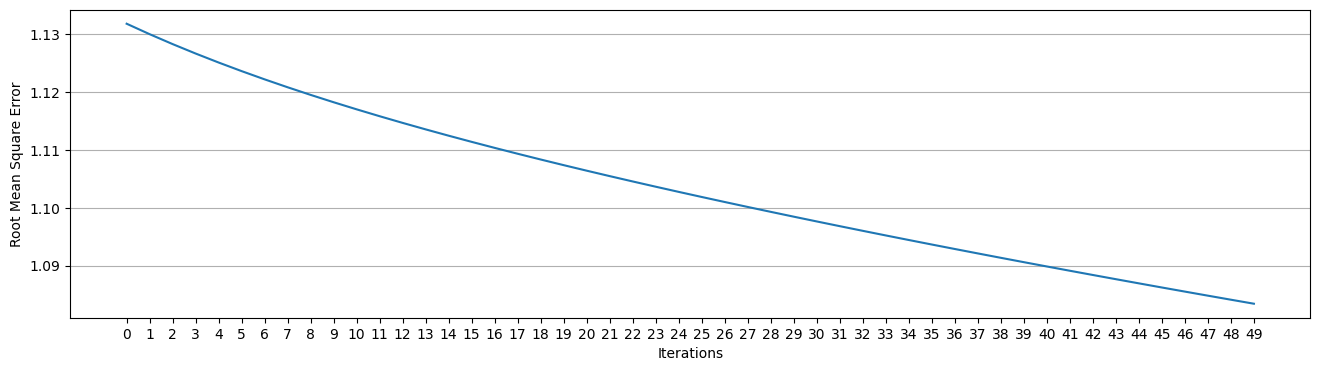

In [ ]:
table = pd.pivot_table(data, values='rating',
                        index='u_id', columns='i_id', fill_value=0)
R = table.values

pred, b, b_u, b_i, loss = mf_sgd(R, iterations=50)
print("P x Q:")
print(pred)
print("Global bias:")
print(b)
print("User bias:")
print(b_u)
print("Item bias:")
print(b_i)
plot_training_loss(loss)

In [ ]:
print(loss[-1])

(49, 1.0834321293130704)


In [ ]:
user_mean_ratings = data.groupby('u_id')['rating'].mean()

item_mean_ratings = data.groupby('i_id')['rating'].mean()

P x Q:
[[4.30632303 4.30650414 4.29228192 ... 4.2962175  4.29518485 4.29409488]
 [4.29156378 4.29135416 4.27971004 ... 4.28004174 4.27867179 4.27517895]
 [4.25146622 4.24929246 4.24502989 ... 4.24327982 4.24086675 4.24581258]
 ...
 [4.28013724 4.28251204 4.27044596 ... 4.26706161 4.27113486 4.26895082]
 [4.25858369 4.25911067 4.24865719 ... 4.25179572 4.24838194 4.24910842]
 [4.26619124 4.26535109 4.25192163 ... 4.25370313 4.24797054 4.24931078]]
Global bias:
4.261657078444715
User bias:
[ 0.0179907   0.00727693 -0.01760358 ...  0.00302718 -0.01624591
 -0.0060138 ]
Item bias:
[0.01496143 0.01268986 0.00382483 ... 0.00328945 0.00360776 0.00310602]


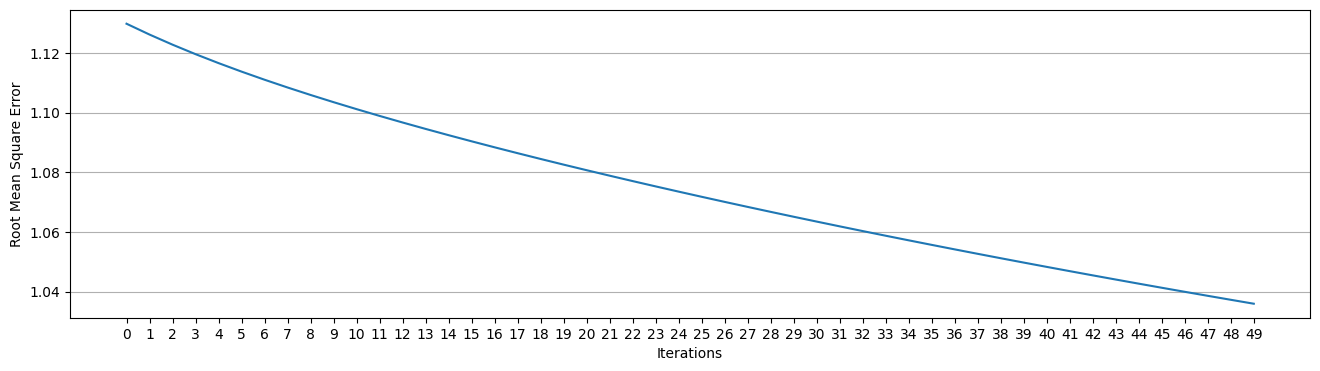

In [ ]:
table = pd.pivot_table(data, values='rating',
                        index='u_id', columns='i_id', fill_value=0)
R = table.values
pred, b, b_u, b_i, loss = mf_sgd(R, iterations=50)
print("P x Q:")
print(pred)
print("Global bias:")
print(b)
print("User bias:")
print(b_u)
print("Item bias:")
print(b_i)
plot_training_loss(loss)

In [ ]:
print(loss[-1])

(49, 1.0359441883509124)


In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.5 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
data = ["I love you", "I hate you"]
sentiment_pipeline(data)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079}]

In [ ]:
data=df_train['reviewText'].tolist()

In [ ]:
def process_long_text(text, max_seq_length=512):
    chunks = [text[i:i + max_seq_length] for i in range(0, len(text), max_seq_length)]
    results = []

    for chunk in chunks:
        result = sentiment_pipeline(chunk)
        results.extend(result)

    return results

In [ ]:
scaled_results = []
for review in data:
    if len(review) <= 512:
        # For short texts, process directly
        result = sentiment_pipeline(review)
        scaled_results.extend(result)
    else:
        # For long texts, split and process
        results = process_long_text(review)
        scaled_results.extend(results)

KeyboardInterrupt: ignored

In [ ]:
len(scaled_results)

8208

In [ ]:
data=df_train[:8208]

In [ ]:
final_results = []
for result in scaled_results:
    original_score = result['score']
    scaled_score = 1 + (original_score - 0) * (5 - 1)
    final_results.append( scaled_score)

In [ ]:
data['BERT_ratings']=final_results

<ipython-input-88-1b46fe02c1dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['BERT_ratings']=final_results


In [ ]:
data = data.rename(columns={
    'overall': 'rating',
    'reviewTime': 'timestamp',
    'reviewerID': 'u_id',
    'asin': 'i_id'
})

In [ ]:
user_mean_ratings_bert = data.groupby('u_id')['BERT_ratings'].mean()

item_mean_ratings_bert = data.groupby('i_id')['BERT_ratings'].mean()

In [ ]:
data=data.drop(['Unnamed: 0','verified','style','reviewerName','reviewText','summary','BERT_ratings'],axis=1)
data.head()

,rating,timestamp,u_id,i_id
0,5.0,2014-02-08,A0009988MRFQ3TROTQPI,B0096W47NO
1,5.0,2014-02-08,A0009988MRFQ3TROTQPI,B00C0YUY4Q
2,5.0,2014-10-03,A0009988MRFQ3TROTQPI,B000BMSUBI
3,5.0,2014-10-20,A0009988MRFQ3TROTQPI,B004XC5LHS
4,5.0,2015-04-18,A0009988MRFQ3TROTQPI,B009INAMA8


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def mf_sgd(R, K=64, alpha=1e-4, beta=1e-2, iterations=50):
    """
    :param R: user-item rating matrix
    :param K: number of latent dimensions
    :param alpha: learning rate
    :param beta: regularization parameter
    """
    num_users, num_items = R.shape

    # Initialize user and item latent feature matrice
    P = np.random.normal(scale=1. / K, size=(num_users, K))
    Q = np.random.normal(scale=1. / K, size=(num_items, K))

    # Initialize the biases
    b_u = np.zeros(num_users)
    b_i = np.zeros(num_items)
    w1 = np.zeros(num_users)
    w2 = np.zeros(num_items)
    w3 = np.zeros(num_users)
    w4 = np.zeros(num_items)
    b = np.mean(R[np.where(R != 0)])

    # Create a list of training samples
    samples = [
        (i, j, R[i, j])
        for i in range(num_users)
        for j in range(num_items)
        if R[i, j] > 0
    ]

    # Perform stochastic gradient descent for number of iterations
    training_loss = []
    pred = np.random.normal(scale=1. / K, size=(num_users, num_items))
    for iters in range(iterations):

        np.random.shuffle(samples)
        # i = , j = , r =
        for i, j, r in samples:
            predict = 0
            predict = b + b_u[i] + b_i[j] + np.dot(P[i], Q[j])+w1[i]*(user_mean_ratings[i]-b)+w2[j]*(item_mean_ratings[j]-b)+w3[i]*(user_mean_ratings_bert[i]-b)+w4[j]*(item_mean_ratings_bert[j]-b)
            err = r - predict
            # gradient dst
            b_u[i] = b_u[i] + alpha * (err - beta * b_u[i])
            b_i[j] = b_i[j] + alpha * (err - beta * b_i[j])

            P[i] = P[i] + alpha * (err * Q[j] - beta * P[i])
            Q[j] = Q[j] + alpha * (err * P[i] - beta * Q[j])

            w1[i] += alpha * (err * (user_mean_ratings[i] - b))
            w2[j] += alpha * (err * (item_mean_ratings[j] - b))
            w1[i] += alpha * (err * (user_mean_ratings_bert[i] - b))
            w2[j] += alpha * (err * (item_mean_ratings_bert[j] - b))

        for i in range(num_users):
            pred[i] = b + b_u[i] + b_i + np.dot(P[i], Q.T)+w1[i]*(user_mean_ratings[i]-b)+w3[i]*(user_mean_ratings_bert[i]-b)
        error = 0
        x_nz, y_zn = R.nonzero()
        for x, y in zip(x_nz, y_zn):
            error += pow(R[x, y] - pred[x, y], 2)
        loss = np.sqrt(error / (len(x_nz)))
        training_loss.append((iters, loss))
        # training error = sum(r[ij]-r_head[ij])square

    return pred, b, b_u, b_i, training_loss


def plot_training_loss(training_loss):
    x = [x for x, y in training_loss]
    y = [y for x, y in training_loss]
    plt.figure(figsize=(16, 4))
    plt.plot(x, y)
    plt.xticks(x, x)
    plt.xlabel("Iterations")
    plt.ylabel("Root Mean Square Error")
    plt.grid(axis="y")
    plt.savefig("training_loss.png")
    plt.show()

In [ ]:
data.shape

(8208, 4)

P x Q:
[[4.30068116 4.3106805  4.30625124 ... 4.29401441 4.30334392 4.29437569]
 [4.28663095 4.29115834 4.2888099  ... 4.27353083 4.28776036 4.27439038]
 [4.25435327 4.25962958 4.26089658 ... 4.24726956 4.2548719  4.24035168]
 ...
 [4.28428434 4.29013554 4.29057054 ... 4.27548296 4.28584834 4.27635056]
 [4.29495968 4.30213125 4.30372605 ... 4.28808262 4.29731644 4.28606681]
 [4.20259979 4.20657358 4.20805324 ... 4.18682456 4.19844507 4.19053014]]
Global bias:
4.272704402515723
User bias:
[ 1.76709078e-02  7.17613437e-03 -1.81373578e-02  2.76885140e-02
  1.06375853e-02  2.76056679e-02  1.40836184e-02  9.26511080e-03
  2.19216131e-02 -6.66090630e-03  5.68919017e-03 -4.04406191e-03
  8.64559949e-03 -1.87849234e-02  3.38020576e-03  1.41900645e-02
 -1.76726028e-03 -1.51881429e-02 -4.52579831e-03  9.37656274e-03
 -2.13706194e-02  1.07212423e-02  1.06772517e-02  1.09964993e-02
 -3.21570872e-02  2.36832378e-03  9.43453902e-04  7.18168736e-03
 -8.94379125e-03 -5.62940883e-02  5.93166381e-02  1.

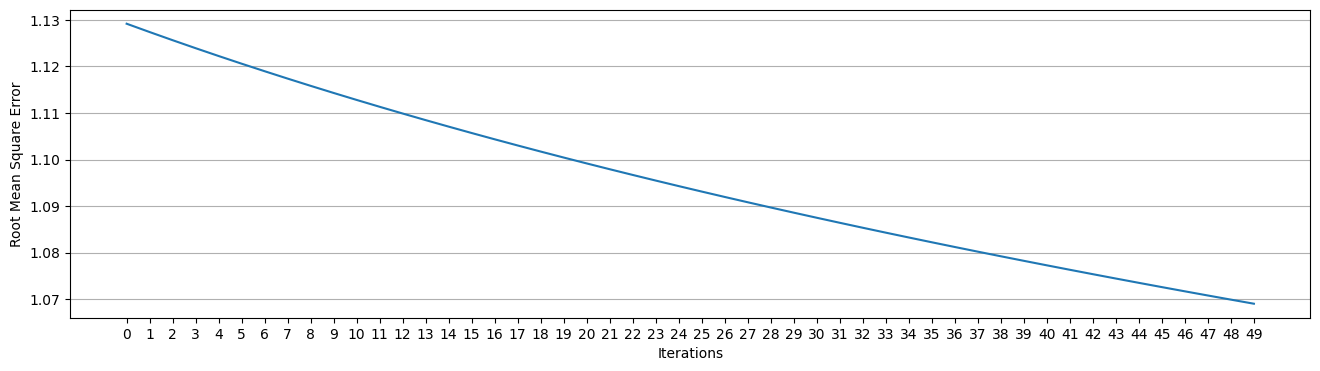

In [ ]:
table = pd.pivot_table(data, values='rating',
                        index='u_id', columns='i_id', fill_value=0)
R = table.values

pred, b, b_u, b_i, loss = mf_sgd(R, iterations=50)
print("P x Q:")
print(pred)
print("Global bias:")
print(b)
print("User bias:")
print(b_u)
print("Item bias:")
print(b_i)
plot_training_loss(loss)

In [ ]:
print(loss[-1])

(49, 1.0690421188808041)


In [ ]:
data.head()

,Unnamed: 0,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,BERT_ratings
0,2207800,5.0,1,2014-02-08,A0009988MRFQ3TROTQPI,B0096W47NO,9,Bob Macky,Let's not just create something to sell toys a...,Lauren Faust took a chance,4.599695
1,2356625,5.0,1,2014-02-08,A0009988MRFQ3TROTQPI,B00C0YUY4Q,9,Bob Macky,"In this case I agree, the first season of my l...",Who says the first is the best,3.574627
2,1042138,5.0,0,2014-10-03,A0009988MRFQ3TROTQPI,B000BMSUBI,3,Bob Macky,Didnt think it could get better..but it did,Probably fav of the series,4.993488
3,1905647,5.0,0,2014-10-20,A0009988MRFQ3TROTQPI,B004XC5LHS,3,Bob Macky,This is My First Anime ive Ever Watched in Jap...,This Will Set The Bar For Me,4.907051
4,3344484,5.0,1,2015-04-18,A0009988MRFQ3TROTQPI,B009INAMA8,9,Bob Macky,Its Really Great i Just Wish That They Had All...,Never Judge A Show Before Hand,4.984904


In [ ]:
file_path = "output.csv"

# Use the to_csv method to save the DataFrame to the specified file
data.to_csv(file_path, index=False)